<a href="https://colab.research.google.com/github/amandeepsaini/green-screen-anywhere/blob/main/Synthetic_Dataset_Creation_And_Initial_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import random

%matplotlib inline

In [7]:
import tensorflow.keras.layers as l

In [38]:
from tensorflow.keras.utils import plot_model

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')
ds_root = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/"

static_bgs_dir = ds_root + "Static BGs"
#video_bgs_dir = ds_root + "Video BGs"
#people_pngs_dir = ds_root + "People PNGs"
animals_pngs_dir = ds_root + "Animal PNGs"

static_bgs_paths = os.listdir(static_bgs_dir)
#video_bgs_paths = os.listdir(video_bgs_dir)
#people_pngs_paths = os.listdir(people_pngs_dir)
animals_pngs_paths = os.listdir(animals_pngs_dir)

Mounted at /content/gdrive/


In [9]:
animals_pngs_paths

['animal-2765318_960_720.png',
 'animal-2664801_960_720.png',
 'animal-2765319_960_720.png',
 'animal-2887947_960_720.png',
 'animal-2884369_960_720.png',
 'animal-2765320_960_720.png',
 'animal-2887950_960_720.png',
 'animal-3328364_960_720.png',
 'animal-3296309_960_720.png',
 'arabian-2186313_960_720.png',
 'bear-1280146_960_720.png',
 'cat-free-2973097_960_720.png',
 '.DS_Store']

In [10]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

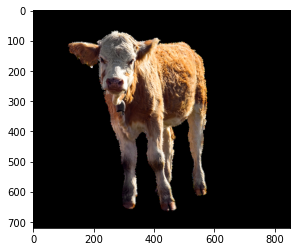

In [11]:
img = cv2.imread(os.path.join(animals_pngs_dir, animals_pngs_paths[0]), cv2.IMREAD_UNCHANGED)
show_img(img)


In [12]:
animals = []
for img_name in animals_pngs_paths:
    if ".png" in img_name:
        animals.append(cv2.imread(os.path.join(animals_pngs_dir, img_name), cv2.IMREAD_UNCHANGED))

static_bgs = []
for img_name in static_bgs_paths:
    if ".jpg" in img_name:
        static_bgs.append(cv2.imread(os.path.join(static_bgs_dir, img_name)))


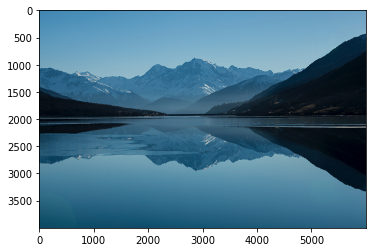

In [13]:
show_img(static_bgs[0])

In [14]:
static_bg_resized = [cv2.resize(img, (0,0), fx=0.1, fy=0.1) for img in static_bgs]

In [15]:
animals_resized = [cv2.resize(img, (0,0), fx=0.2, fy=0.2) for img in animals]

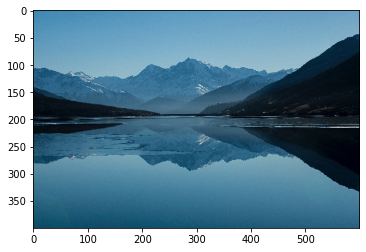

In [16]:
show_img(static_bg_resized[0])

# Code for datageneration

In [17]:
# Obtained and adpated from https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
def overlay_transparent(background, overlay, x, y, return_alpha_mask=False):
    background = background.copy()
    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image
    if return_alpha_mask:
      alpha_mask = np.zeros_like(background).astype(np.float32)
      alpha_mask[y:y+h, x:x+w] = mask
      return background, alpha_mask

    else:
      return background

In [18]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([

    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.

], random_order=True) # apply augmenters in random order


In [19]:
def augment(images):
  return seq(images=images)

## Data Generator

In [20]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=16, epoch_len=1000, bgs=[], overlays=[], resize=True, resize_res=160, 
                 augment_bg=False, augment_overlay=False, augment_input2=False, return_alpha_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.epoch_len = epoch_len
        self.bgs = bgs
        self.overlays = overlays
        self.resize = resize
        self.resize_res = resize_res
        self.augment_bg = augment_bg
        self.augment_overlay = augment_overlay
        self.augment_input2 = augment_input2
        self.return_alpha_mask = return_alpha_mask
        
    def __len__(self):
        return self.epoch_len

    def __getitem__(self, index):
        batch_input1 = np.zeros((self.batch_size, self.resize_res,self.resize_res,3)).astype(np.float32)
        batch_input2 = np.zeros((self.batch_size, self.resize_res,self.resize_res,3)).astype(np.float32)
        batch_labels = np.zeros((self.batch_size, self.resize_res,self.resize_res,3)).astype(np.float32)

        for i in range(self.batch_size):
            bg = random.choice(self.bgs)
            overlay = random.choice(self.overlays)
                                    
            black = np.zeros_like(bg)
            
            rand_x = random.randint(0,int(bg.shape[1]*.8))
            rand_y = random.randint(0,int(bg.shape[0]*.8))
            
            if self.augment_bg:
              bg = augment(bg)
            # if self.augment_overlay:
            #   overlay = augment(overlay)

            input1, alpha_mask = overlay_transparent(bg, overlay, rand_x, rand_y, return_alpha_mask=True)
            input2 = bg
            if self.return_alpha_mask:
              label = alpha_mask
            else:
              label = overlay_transparent(black, overlay, rand_x, rand_y)
        
            if self.resize:
                input1 = cv2.resize(input1, (self.resize_res,self.resize_res))
                input2 = cv2.resize(input2, (self.resize_res,self.resize_res))
                label = cv2.resize(label, (self.resize_res,self.resize_res))
            batch_input1[i] = input1
            batch_input2[i] = input2
            batch_labels[i] = label


        if self.augment_input2:
          batch_input2 = augment(batch_input2)
        if self.return_alpha_mask:
          return (batch_input1/255., batch_input2/255.), batch_labels
        else:
          return (batch_input1/255., batch_input2/255.), batch_labels/255.
        

In [46]:
generator = DataGenerator(batch_size=4, epoch_len=10, 
                          bgs=static_bg_resized, overlays=animals_resized, resize_res=150)

(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


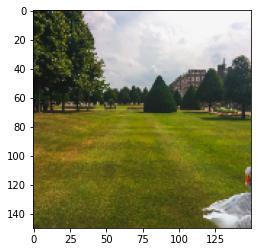

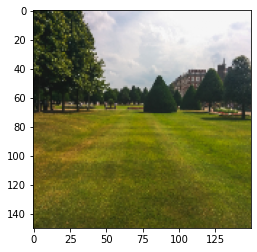

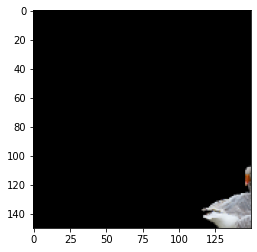

In [47]:
for output in generator:
    (input1, input2), label = output
    print(input1[0].shape)
    print(input2[0].shape)
    print(label[0].shape)
    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    break

# Code for Initial Model Expirements


In [18]:
def create_simple_seperable_conv_nn():
    input1 = l.Input(shape=[150,150,3])
    input2 = l.Input(shape=[150,150,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.SeparableConv2D(32, 5, padding='same')(input_concat)
    z = l.SeparableConv2D(32, 3, padding='same')(z)
    z = l.SeparableConv2D(3, 3, padding='same')(z)

    return keras.Model(inputs=[input1,input2], outputs=[z])

In [19]:
model1 = create_simple_seperable_conv_nn()
model1.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 150, 150, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 150, 150, 32) 374         concatenate[0][0]            

In [20]:
train_generator = DataGenerator(batch_size=16, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True)
model1.fit_generator(generator=train_generator, epochs=3, use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 20s 130ms/step - loss: 0.0129 - MAE: 0.0432
Epoch 2/3
100/100 [==============================] - 13s 129ms/step - loss: 0.0121 - MAE: 0.0462
Epoch 3/3
100/100 [==============================] - 13s 129ms/step - loss: 0.0104 - MAE: 0.0432


(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


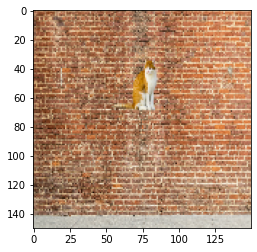

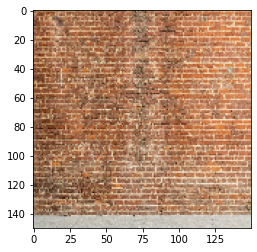

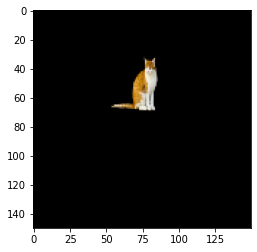

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


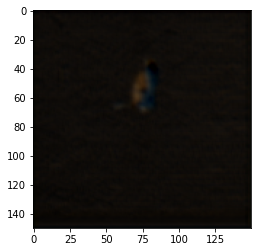

In [21]:
for output in generator:
    (input1, input2), label = output
    print(input1[0].shape)
    print(input2[0].shape)
    print(label[0].shape)
    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    show_img(model1.predict((input1, input2))[0])
    break

In [22]:
def create_simple_seperable_conv_nn_with_skips():
    input1 = l.Input(shape=[150,150,3])
    input2 = l.Input(shape=[150,150,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.SeparableConv2D(32, 7, padding='same')(input_concat)
    z = l.SeparableConv2D(32, 5, padding='same')(z)
    z = l.SeparableConv2D(3, 3, padding='same')(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(32, 3, padding='same')(z)
    z = l.SeparableConv2D(3, 3, padding='same')(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(3, 3, padding='same')(z)

    return keras.Model(inputs=[input1,input2], outputs=[z])

In [23]:
model2 = create_simple_seperable_conv_nn_with_skips()
model2.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 150, 150, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_3 (SeparableCo (None, 150, 150, 32) 518         concatenate_1[0][0]        

In [24]:
train_generator = DataGenerator(batch_size=16, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True)
model2.fit_generator(generator=train_generator, epochs=3, use_multiprocessing=True)

Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 24s 227ms/step - loss: 0.0163 - MAE: 0.0646
Epoch 2/3
100/100 [==============================] - 23s 227ms/step - loss: 0.0128 - MAE: 0.0514
Epoch 3/3
100/100 [==============================] - 23s 230ms/step - loss: 0.0110 - MAE: 0.0472


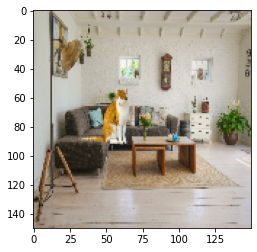

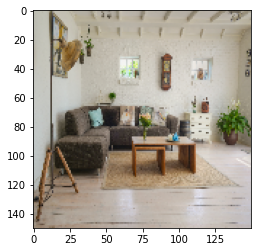

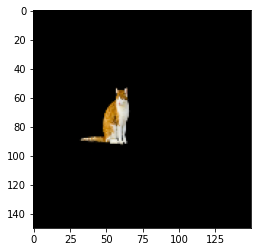

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


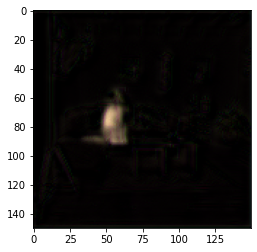

In [28]:
for output in generator:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    show_img(model2.predict((input1, input2))[0])
    break

In [17]:
def pyramid_pooling_module(x):
  pool1 = l.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  pool1 = l.Conv2D(10,1)(pool1)
  pool1 = l.UpSampling2D(size=(2,2), interpolation='bilinear')(pool1)

  pool2 = l.MaxPool2D(pool_size=(4,4), strides=(4,4))(x)
  pool2 = l.Conv2D(10,1)(pool2)
  pool2 = l.UpSampling2D(size=(4,4), interpolation='bilinear')(pool2)

  pool3 = l.MaxPool2D(pool_size=(8,8), strides=(8,8))(x)
  pool3 = l.Conv2D(10,1)(pool3)
  pool3 = l.UpSampling2D(size=(8,8), interpolation='bilinear')(pool3)

  pool4 = l.MaxPool2D(pool_size=(16,16), strides=(16,16))(x)
  pool4 = l.Conv2D(10,1)(pool4)
  pool4 = l.UpSampling2D(size=(16,16), interpolation='bilinear')(pool4)

  output = l.Concatenate(axis=-1)([x, pool1, pool2, pool3, pool4])

  return output


In [54]:
def create_pp_based_model():
    input1 = l.Input(shape=[160,160,3])
    input2 = l.Input(shape=[160,160,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.Conv2D(32, 3, padding='same')(input_concat)
    z = l.Conv2D(32, 3, padding='same')(z)
    z = pyramid_pooling_module(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(32, 3, padding='same')(z)
    z = l.Conv2D(3, 1, padding='same')(z)
    return keras.Model(inputs=[input1,input2], outputs=[z])

In [55]:
model3 = create_pp_based_model()
model3.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])
model3.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 160, 160, 6)  0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 160, 160, 32) 1760        concatenate_13[0][0]       

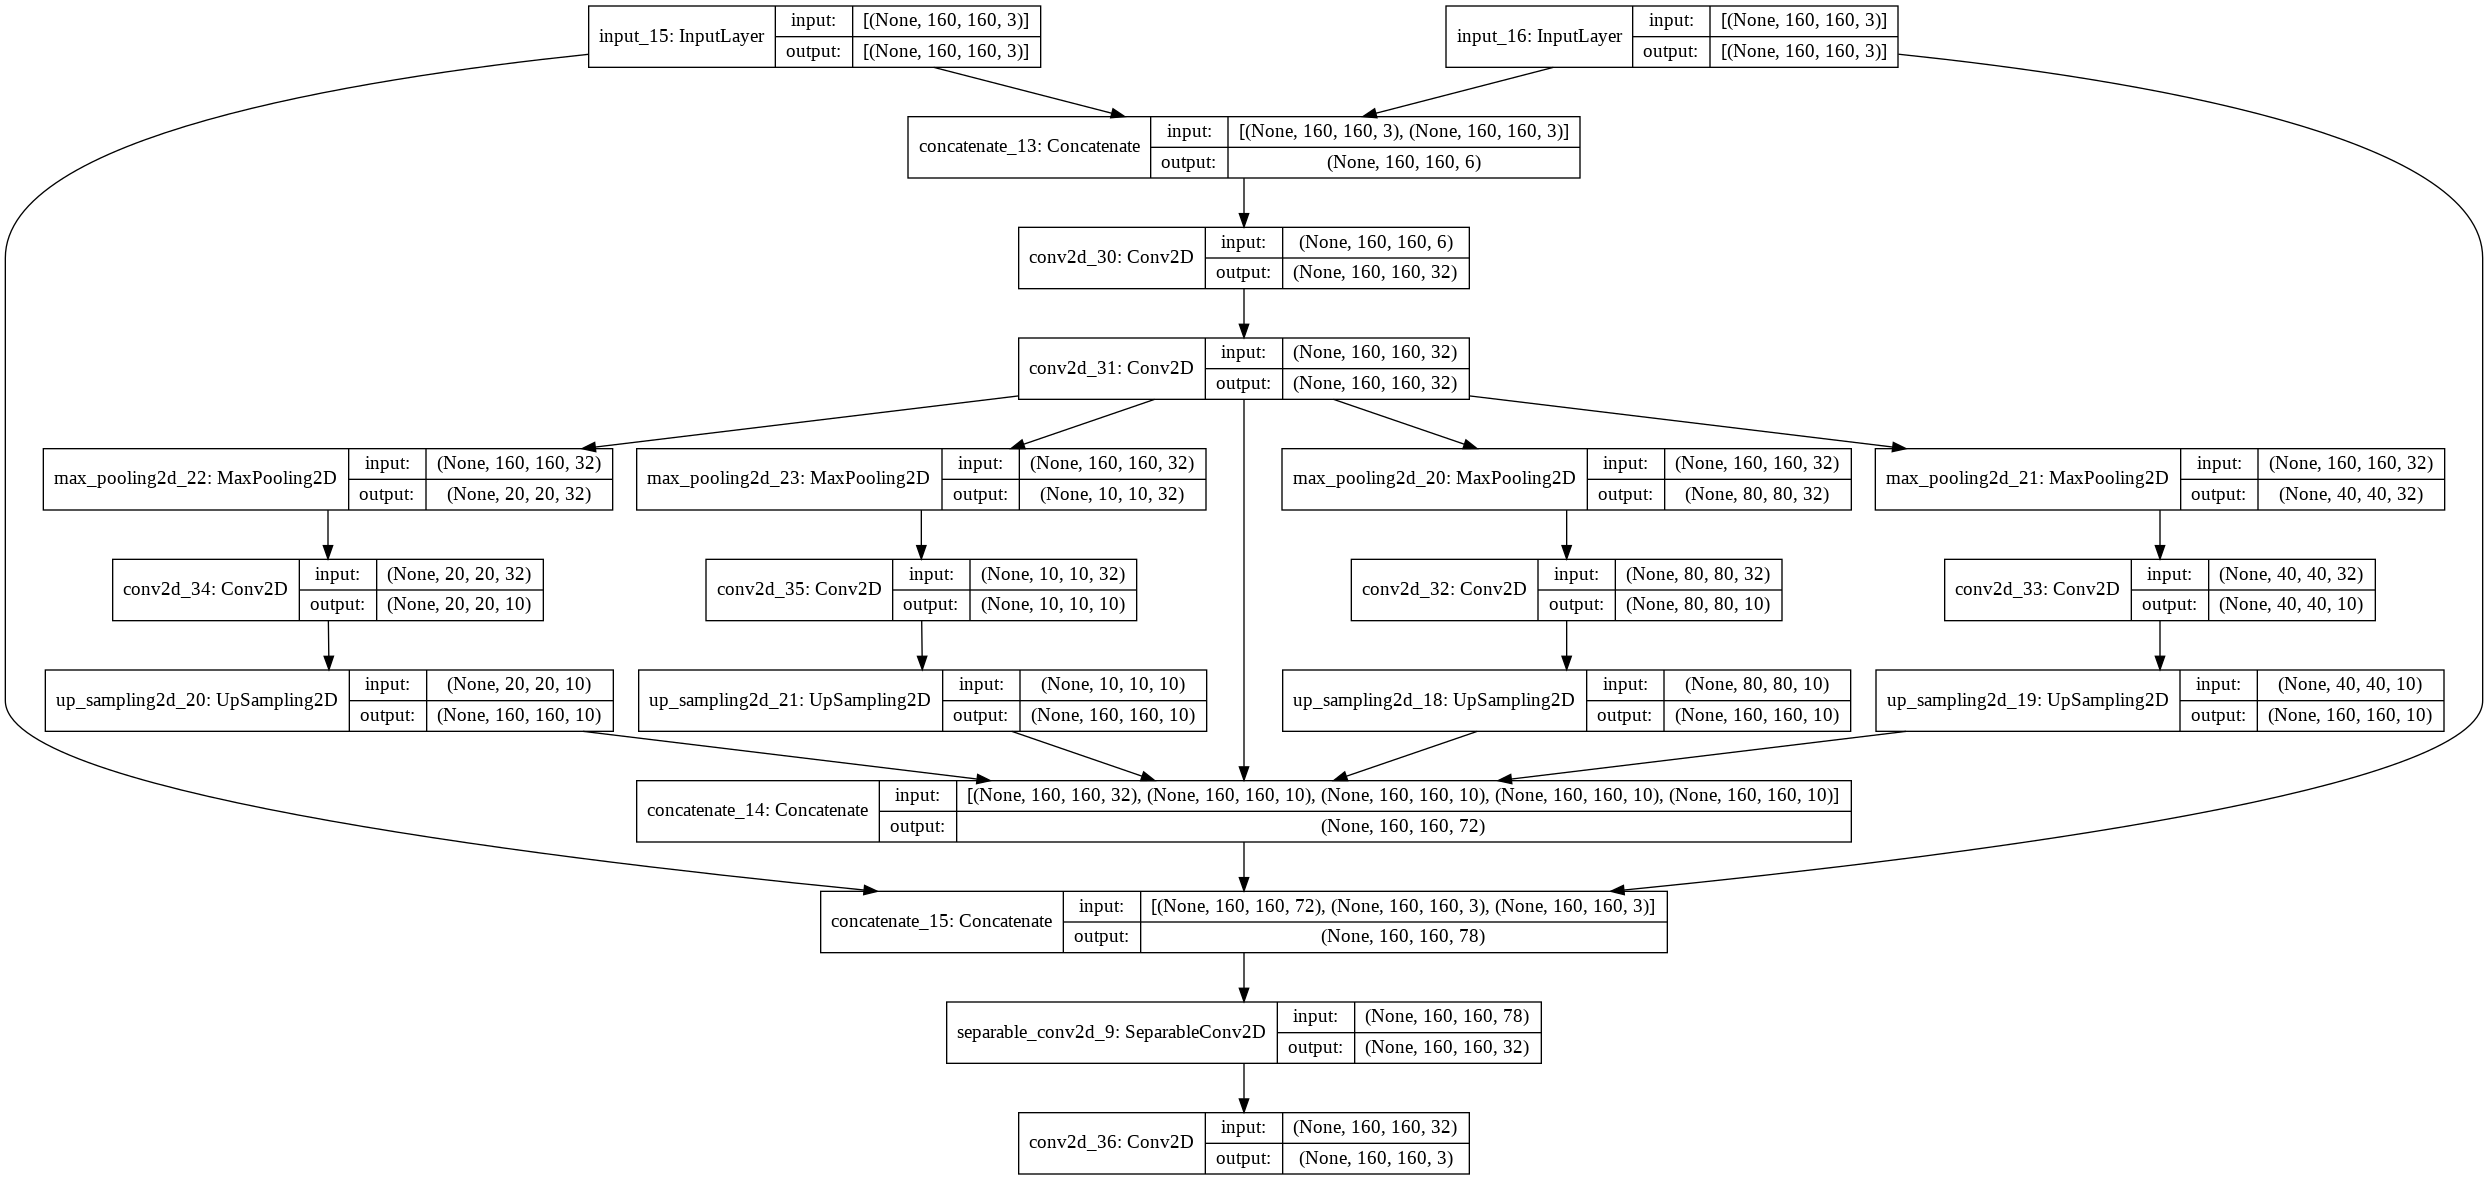

In [58]:
plot_model(model3, show_shapes=True)

In [63]:
train_generator = DataGenerator(batch_size=16, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160)
model3.fit_generator(generator=train_generator, epochs=3, use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 13s 112ms/step - loss: 0.0108 - MAE: 0.0463
Epoch 2/3
100/100 [==============================] - 13s 124ms/step - loss: 0.0043 - MAE: 0.0266
Epoch 3/3
100/100 [==============================] - 12s 122ms/step - loss: 0.0042 - MAE: 0.0259


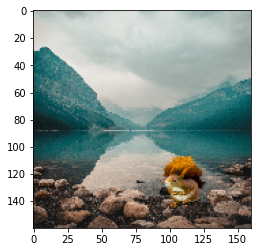

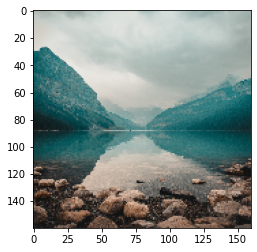

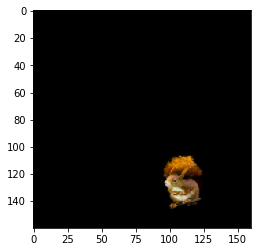

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


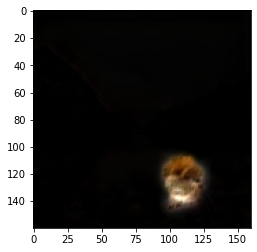

In [68]:
for output in train_generator:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    show_img(model3.predict((input1, input2))[0])
    break

In [69]:
train_generator = DataGenerator(batch_size=64, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160)
model3.fit_generator(generator=train_generator, epochs=3, use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 47s 449ms/step - loss: 0.0036 - MAE: 0.0225
Epoch 2/3
100/100 [==============================] - 48s 475ms/step - loss: 0.0033 - MAE: 0.0217
Epoch 3/3
100/100 [==============================] - 48s 475ms/step - loss: 0.0032 - MAE: 0.0211


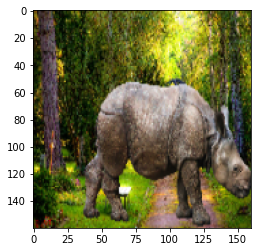

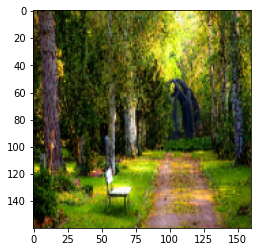

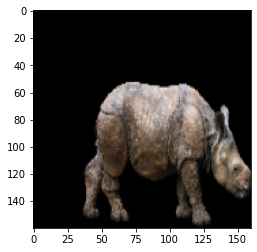

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


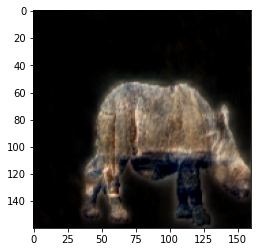

In [73]:
for output in train_generator:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    show_img(model3.predict((input1, input2))[0])
    break

In [99]:
train_generator = DataGenerator(batch_size=64, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160, augment_input2=True, augment_bg=False)
model3.fit_generator(generator=train_generator, epochs=5, use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 86s 854ms/step - loss: 0.0042 - MAE: 0.0327
Epoch 2/5
100/100 [==============================] - 89s 883ms/step - loss: 0.0038 - MAE: 0.0301
Epoch 3/5
100/100 [==============================] - 89s 882ms/step - loss: 0.0036 - MAE: 0.0289
Epoch 4/5
100/100 [==============================] - 89s 880ms/step - loss: 0.0036 - MAE: 0.0290
Epoch 5/5
100/100 [==============================] - 89s 879ms/step - loss: 0.0035 - MAE: 0.0283


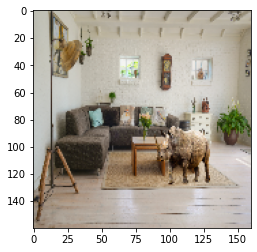

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


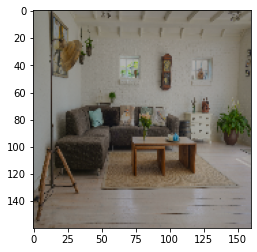

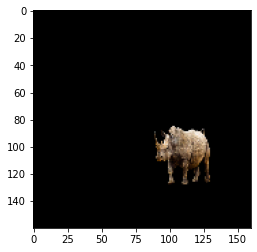

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


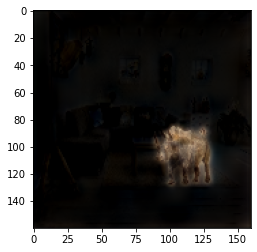

In [102]:
for output in train_generator:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    show_img(model3.predict((input1, input2))[0])

    break

## Lets try making the output just the alpha values

In [18]:
def create_pp_based_model_alpha_out():
    input1 = l.Input(shape=[160,160,3])
    input2 = l.Input(shape=[160,160,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.Conv2D(32, 3, padding='same')(input_concat)
    z = l.Conv2D(32, 3, padding='same')(z)
    z = pyramid_pooling_module(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(32, 3, padding='same')(z)
    z = l.Conv2D(1, 1, padding='same')(z)
    return keras.Model(inputs=[input1,input2], outputs=[z])

In [21]:
model4 = create_pp_based_model_alpha_out()
model4.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])


In [22]:
train_generator_alpha_label = DataGenerator(batch_size=64, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160, augment_input2=True, augment_bg=False, return_alpha_mask=True)
model4.fit_generator(generator=train_generator_alpha_label, epochs=3, use_multiprocessing=True)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
100/100 [==============================] - 85s 791ms/step - loss: 0.0425 - MAE: 0.1028
Epoch 2/3
100/100 [==============================] - 87s 857ms/step - loss: 0.0157 - MAE: 0.0642
Epoch 3/3
100/100 [==============================] - 87s 857ms/step - loss: 0.0132 - MAE: 0.0555


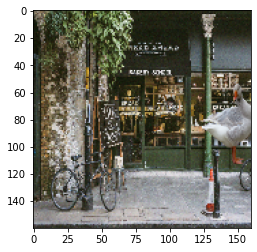

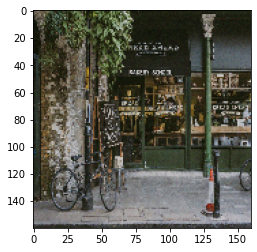

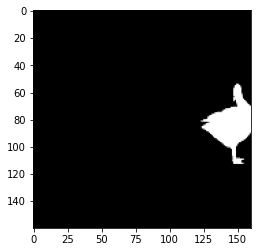

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


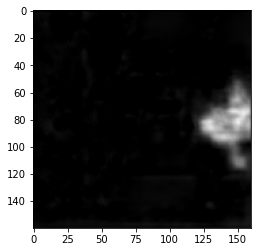

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


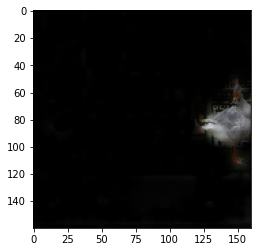

In [27]:
for output in train_generator_alpha_label:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    model_out = model4.predict((input1, input2))
    show_img(model_out[0])
    show_img(model_out[0] * input1[0])

    
    break

In [30]:
model4.save('/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model4_3epoch')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model4_3epoch/assets


In [31]:
train_generator_alpha_label = DataGenerator(batch_size=64, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160, augment_input2=True, augment_bg=False, return_alpha_mask=True)
model4.fit_generator(generator=train_generator_alpha_label, epochs=20, use_multiprocessing=True)
model4.save('/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model4_20epoch')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 83s 825ms/step - loss: 0.0120 - MAE: 0.0520
Epoch 2/20
100/100 [==============================] - 86s 851ms/step - loss: 0.0116 - MAE: 0.0503
Epoch 3/20
100/100 [==============================] - 87s 857ms/step - loss: 0.0112 - MAE: 0.0488
Epoch 4/20
100/100 [==============================] - 86s 855ms/step - loss: 0.0109 - MAE: 0.0478
Epoch 5/20
100/100 [==============================] - 86s 846ms/step - loss: 0.0105 - MAE: 0.0466
Epoch 6/20
100/100 [==============================] - 85s 846ms/step - loss: 0.0102 - MAE: 0.0462
Epoch 7/20
100/100 [==============================] - 85s 843ms/step - loss: 0.0100 - MAE: 0.0454
Epoch 8/20
100/100 [==============================] - 85s 841ms/step - loss: 0.0095 - MAE: 0.0438
Epoch 9/20
100/100 [==============================] - 85s 841ms/step - loss: 0.0095 - MAE: 0.0440
Epoch 10/20
100/100 [==============================] - 85s 842ms/step - loss: 0.0094 - MAE: 0.0444
Epoch 11/20
100/100

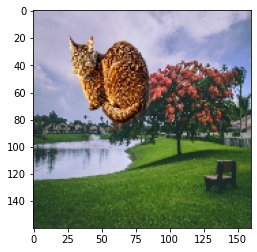

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


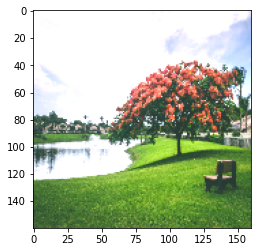

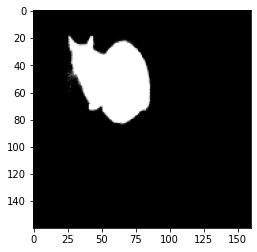

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


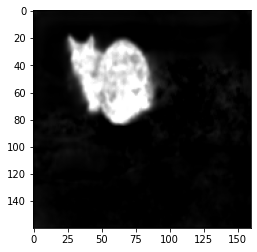

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


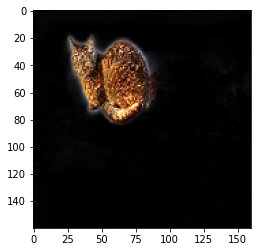

In [36]:
for output in train_generator_alpha_label:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])
    show_img(label[0])
    model_out = model4.predict((input1, input2))
    show_img(model_out[0])
    show_img(model_out[0] * input1[0])
    break

### I realize I forget to give activations to the layers, lets fix that

In [21]:
def pyramid_pooling_module(x):
  pool1 = l.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  pool1 = l.Conv2D(10,1, activation='relu')(pool1)
  pool1 = l.UpSampling2D(size=(2,2), interpolation='bilinear')(pool1)

  pool2 = l.MaxPool2D(pool_size=(4,4), strides=(4,4))(x)
  pool2 = l.Conv2D(10,1, activation='relu')(pool2)
  pool2 = l.UpSampling2D(size=(4,4), interpolation='bilinear')(pool2)

  pool3 = l.MaxPool2D(pool_size=(8,8), strides=(8,8))(x)
  pool3 = l.Conv2D(10,1, activation='relu')(pool3)
  pool3 = l.UpSampling2D(size=(8,8), interpolation='bilinear')(pool3)

  pool4 = l.MaxPool2D(pool_size=(16,16), strides=(16,16))(x)
  pool4 = l.Conv2D(10,1, activation='relu')(pool4)
  pool4 = l.UpSampling2D(size=(16,16), interpolation='bilinear')(pool4)

  output = l.Concatenate(axis=-1)([x, pool1, pool2, pool3, pool4])

  return output

def create_pp_based_model_alpha_out_relu():
    input1 = l.Input(shape=[160,160,3])
    input2 = l.Input(shape=[160,160,3])
    input_concat = l.Concatenate(axis=-1)([input1, input2])
    z = l.Conv2D(32, 3,  activation='relu', padding='same')(input_concat)
    z = l.Conv2D(32, 3,  activation='relu', padding='same')(z)
    z = pyramid_pooling_module(z)
    z = l.Concatenate(axis=-1)([z, input1, input2])
    z = l.SeparableConv2D(32, 3,  activation='relu', padding='same')(z)
    z = l.Conv2D(1, 1,  activation='relu', padding='same')(z)
    return keras.Model(inputs=[input1,input2], outputs=[z])

In [23]:
model5 = create_pp_based_model_alpha_out_relu()
model5.compile(loss='MSE', optimizer=keras.optimizers.Adam(1e-3), metrics=["MAE"])

train_generator_alpha_label = DataGenerator(batch_size=64, epoch_len=100, 
                          bgs=static_bg_resized, overlays=animals_resized, resize=True, resize_res=160, augment_input2=True, augment_bg=False, return_alpha_mask=True)
model5.fit_generator(generator=train_generator_alpha_label, epochs=20, use_multiprocessing=True)
model5.save('/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model5_20epoch')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 85s 752ms/step - loss: 0.0361 - MAE: 0.0746
Epoch 2/20
100/100 [==============================] - 88s 867ms/step - loss: 0.0097 - MAE: 0.0238
Epoch 3/20
100/100 [==============================] - 88s 865ms/step - loss: 0.0066 - MAE: 0.0176
Epoch 4/20
100/100 [==============================] - 87s 860ms/step - loss: 0.0049 - MAE: 0.0140
Epoch 5/20
100/100 [==============================] - 86s 852ms/step - loss: 0.0045 - MAE: 0.0124
Epoch 6/20
100/100 [==============================] - 86s 854ms/step - loss: 0.0044 - MAE: 0.0126
Epoch 7/20
100/100 [==============================] - 86s 852ms/step - loss: 0.0035 - MAE: 0.0105
Epoch 8/20
100/100 [==============================] - 86s 852ms/step - loss: 0.0032 - MAE: 0.0097
Epoch 9/20
100/100 [==============================] - 86s 849ms/step - loss: 0.0029 - MAE: 0.0090
Epoch 10/20
100/100 [==============================] - 86s 847ms/step - loss: 0.0027 - MAE: 0.0084
Epoch 11/20
100/100

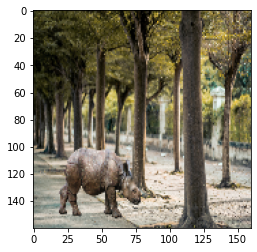

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


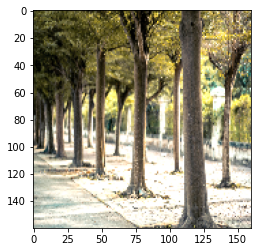

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


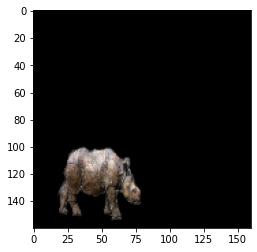

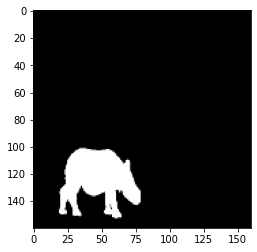

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


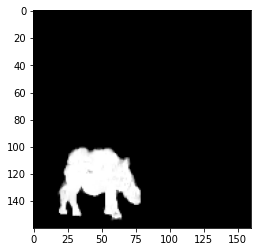

In [35]:
for output in train_generator_alpha_label:
    (input1, input2), label = output    
    show_img(input1[0])
    show_img(input2[0])

    model_out = model5.predict((input1, input2))
    show_img(model_out[0] * input1[0])  
    show_img(label[0])
    show_img(model_out[0])
  
    break

results look great!

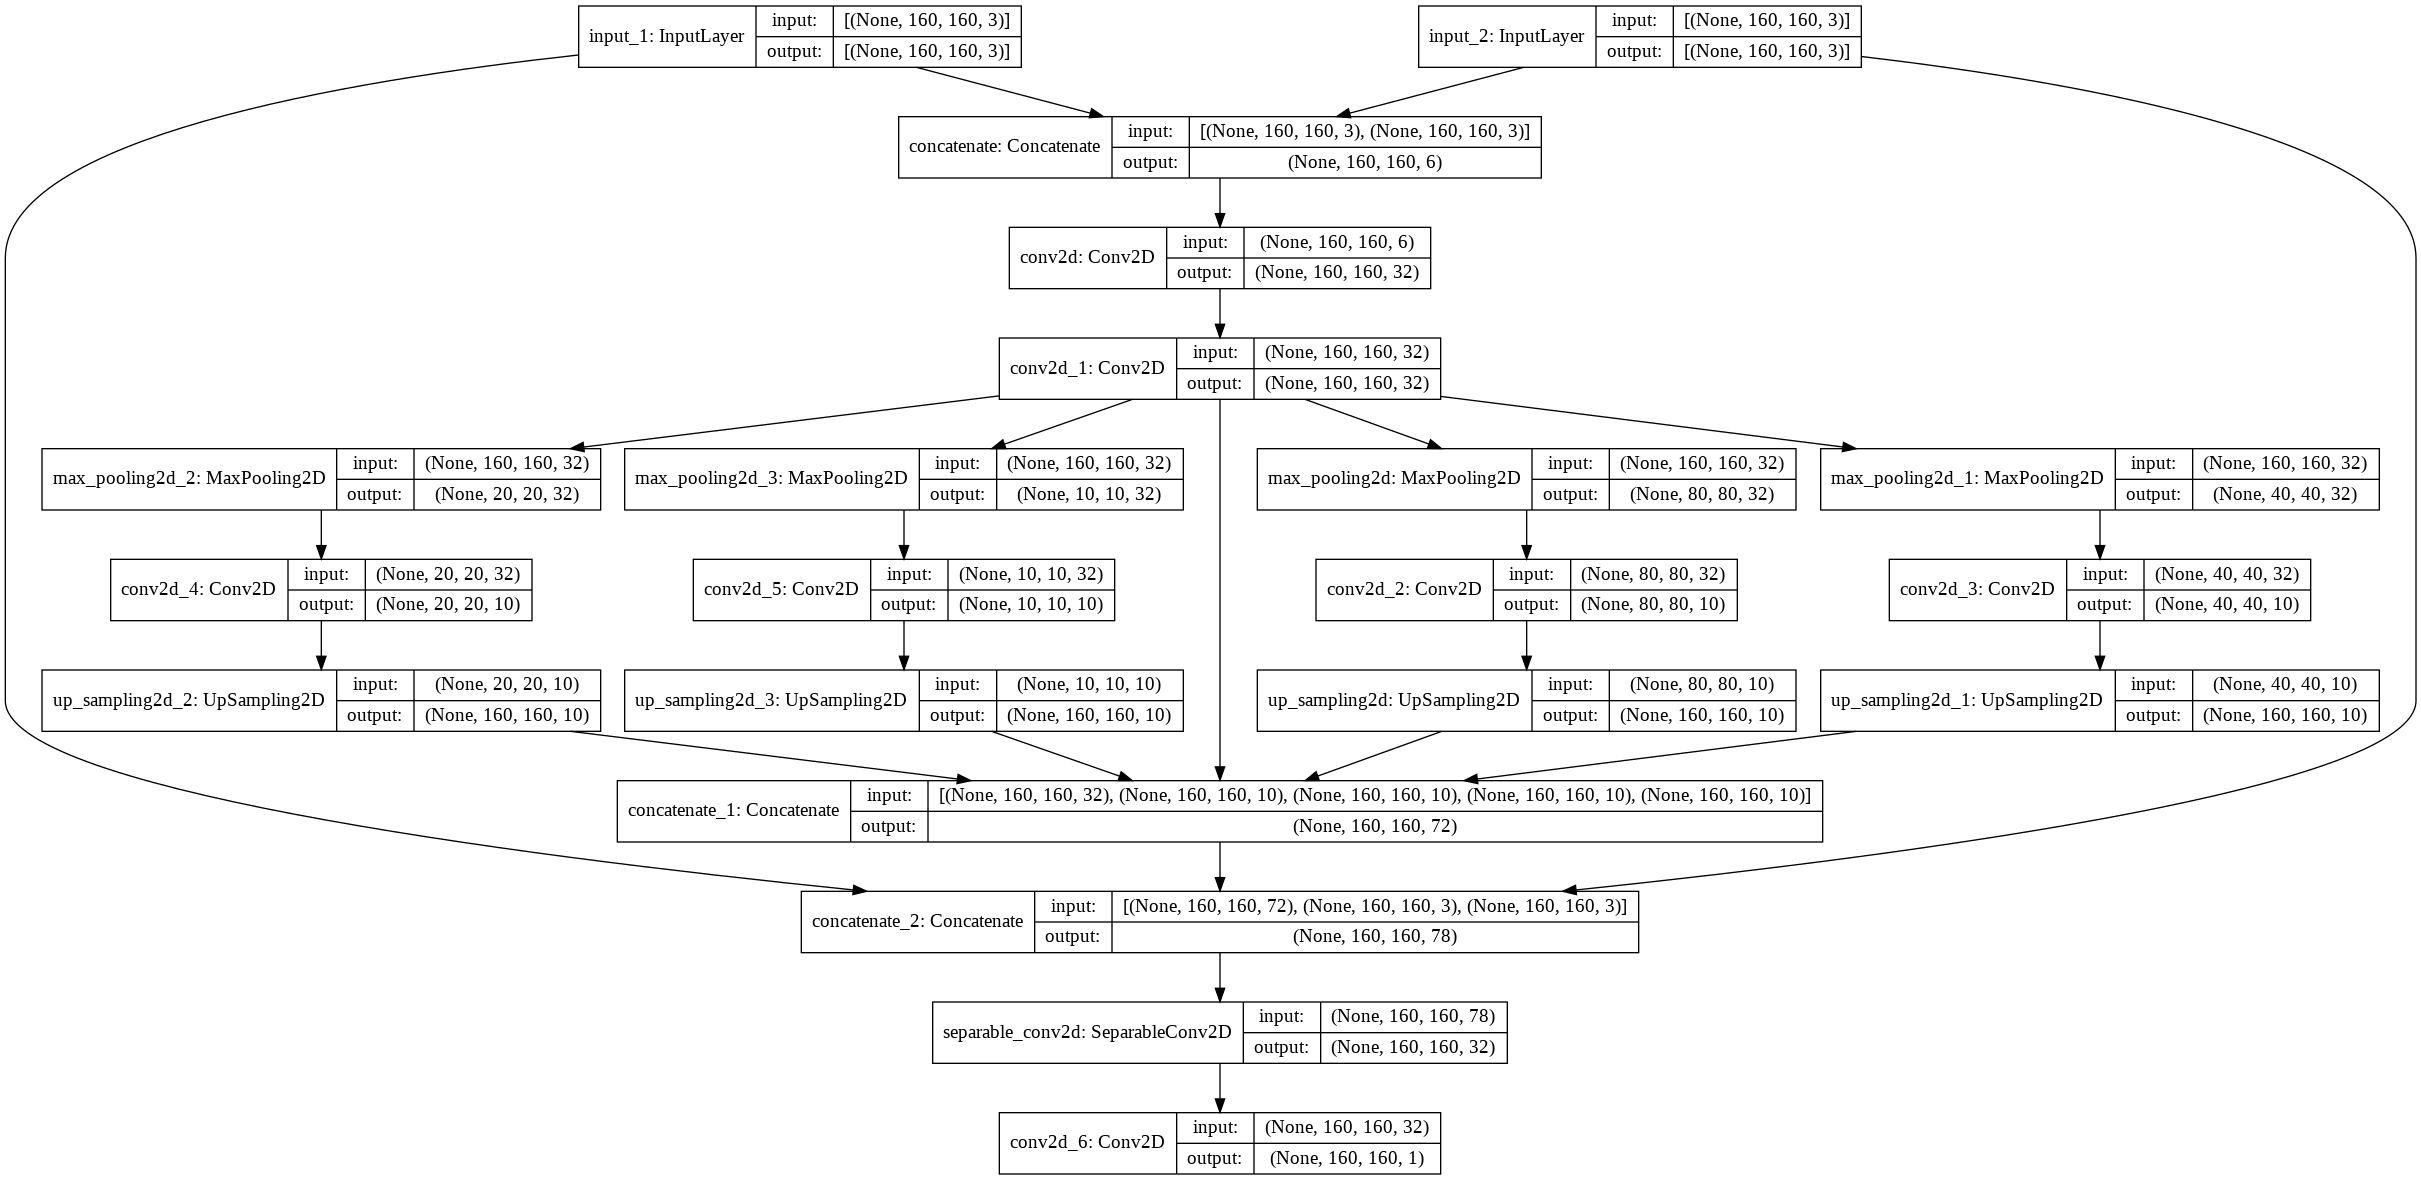

In [39]:
plot_model(model5, show_shapes=True)